In [89]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import SqueezeNet
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [90]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [91]:
artifact_path = Path("../../artifacts/squeezenet")
data_path = Path("../../data/gtsrb")

In [92]:
device = torch.device("cuda:0")

# data

In [93]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [94]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [95]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [96]:
num_class = 43

In [97]:
len(train_dataset)

26640

13


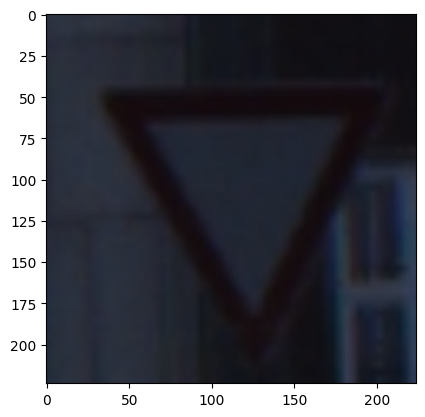

In [98]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [99]:
model = SqueezeNet(output_size=num_class, version="1.1").to(device)

In [100]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
SqueezeNet                                         --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            1,792
│    │    └─ReLU: 3-2                              --
│    └─MaxPool2d: 2-2                              --
│    └─FireModule: 2-3                             --
│    │    └─Conv2dNormActivation: 3-3              1,040
│    │    └─Conv2dNormActivation: 3-4              1,088
│    │    └─Conv2dNormActivation: 3-5              9,280
│    └─ResBlock: 2-4                               --
│    │    └─FireModule: 3-6                        12,432
│    │    └─Identity: 3-7                          --
│    └─MaxPool2d: 2-5                              --
│    └─FireModule: 2-6                             --
│    │    └─Conv2dNormActivation: 3-8              4,128
│    │    └─Conv2dNormActivation: 3-9              4,224
│

# training

In [101]:
epoches = 30
acc_iters = 256 // BATCH_SIZE

In [102]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [103]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [104]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [01:00<00:00,  6.84it/s]


epoch 1 : 0.013780091029520217


100%|██████████| 416/416 [00:57<00:00,  7.19it/s]


epoch 2 : 0.012924502243269952


100%|██████████| 416/416 [00:59<00:00,  7.00it/s]


epoch 3 : 0.012105761270504445


100%|██████████| 416/416 [00:59<00:00,  6.97it/s]


epoch 4 : 0.010239492579085682


100%|██████████| 416/416 [01:00<00:00,  6.84it/s]


epoch 5 : 0.008698477656043205


100%|██████████| 416/416 [01:00<00:00,  6.88it/s]


epoch 6 : 0.007803850039356173


100%|██████████| 416/416 [00:59<00:00,  7.01it/s]


epoch 7 : 0.007287546443806674


100%|██████████| 416/416 [00:59<00:00,  6.94it/s]


epoch 8 : 0.006443018700967793


100%|██████████| 416/416 [01:02<00:00,  6.62it/s]


epoch 9 : 0.005614385905993493


100%|██████████| 416/416 [00:58<00:00,  7.12it/s]


epoch 10 : 0.00472848249494116


100%|██████████| 416/416 [01:04<00:00,  6.44it/s]


epoch 11 : 0.003965902253045128


100%|██████████| 416/416 [01:01<00:00,  6.79it/s]


epoch 12 : 0.00344938045712367


100%|██████████| 416/416 [00:59<00:00,  6.94it/s]


epoch 13 : 0.003248936172615056


100%|██████████| 416/416 [01:05<00:00,  6.38it/s]


epoch 14 : 0.002750951763888364


100%|██████████| 416/416 [01:05<00:00,  6.36it/s]


epoch 15 : 0.0024672592107190913


100%|██████████| 416/416 [01:04<00:00,  6.47it/s]


epoch 16 : 0.0023622298972790865


100%|██████████| 416/416 [01:00<00:00,  6.91it/s]


epoch 17 : 0.0023571480130787957


100%|██████████| 416/416 [00:55<00:00,  7.44it/s]


epoch 18 : 0.002173178597401532


100%|██████████| 416/416 [00:56<00:00,  7.37it/s]


epoch 19 : 0.002088413598392855


100%|██████████| 416/416 [00:57<00:00,  7.27it/s]


epoch 20 : 0.00215941451922565


100%|██████████| 416/416 [00:55<00:00,  7.44it/s]


epoch 21 : 0.0020731980825635567


100%|██████████| 416/416 [00:54<00:00,  7.61it/s]


epoch 22 : 0.0021278744541352633


100%|██████████| 416/416 [00:54<00:00,  7.57it/s]


epoch 23 : 0.0020057813378046444


100%|██████████| 416/416 [00:59<00:00,  6.99it/s]


epoch 24 : 0.002014115939975734


100%|██████████| 416/416 [00:58<00:00,  7.07it/s]


epoch 25 : 0.0019100884624444565


100%|██████████| 416/416 [00:57<00:00,  7.25it/s]


epoch 26 : 0.0019528119443678476


100%|██████████| 416/416 [00:59<00:00,  7.04it/s]


epoch 27 : 0.0019164650587369509


100%|██████████| 416/416 [01:02<00:00,  6.62it/s]


epoch 28 : 0.0019028796544463288


100%|██████████| 416/416 [00:56<00:00,  7.37it/s]


epoch 29 : 0.001873241419511592


100%|██████████| 416/416 [00:57<00:00,  7.18it/s]

epoch 30 : 0.001872978207057503


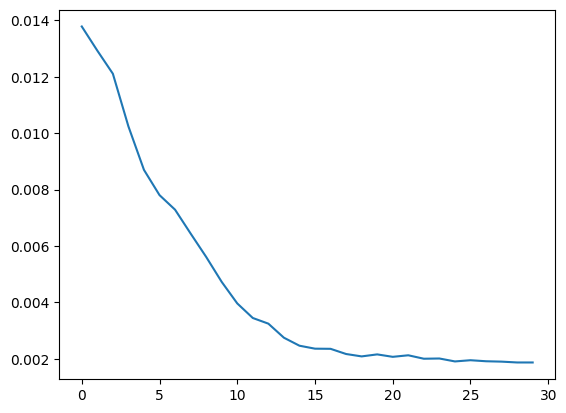

In [105]:
plt.plot(training_loss)

# inference

In [106]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [107]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [108]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [109]:
evaluator = ClassificationEvaluator(num_class, device)

In [110]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:24<00:00,  8.10it/s]

[[  2  12   0 ...   0   0   0]
 [  0 694   3 ...   0   0   0]
 [  0   5 728 ...   0   0   0]
 ...
 [ 24   0   0 ...   0   0   0]
 [ 35   1   0 ...   0   0   0]
 [ 49   3   0 ...   0   0   0]]


In [111]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.03333333333333333
1         : 0.9638888888888889
2         : 0.9706666666666667
3         : 0.8733333333333333
4         : 0.9166666666666666
5         : 0.9746031746031746
6         : 0.0
7         : 0.9444444444444444
8         : 0.8666666666666667
9         : 0.9916666666666667
10        : 0.9954545454545455
11        : 0.9142857142857143
12        : 0.9043478260869565
13        : 0.9972222222222222
14        : 0.8740740740740741
15        : 0.9142857142857143
16        : 0.0
17        : 0.7888888888888889
18        : 0.7871794871794872
19        : 0.0
20        : 1.0
21        : 0.6444444444444445
22        : 0.975
23        : 0.0
24        : 0.9444444444444444
25        : 0.95
26        : 0.9777777777777777
27        : 0.0
28        : 0.9866666666666667
29        : 1.0
30        : 0.58
31        : 0.9259259259259259
32        : 0.0
33        : 0.0
34        : 0.9666666666666667
35        : 0.9641025641025641
36        : 0.0
37        : 0.0
38        : 0.8521739130434

In [112]:
per_class_acc.mean()

0.6183563215797797

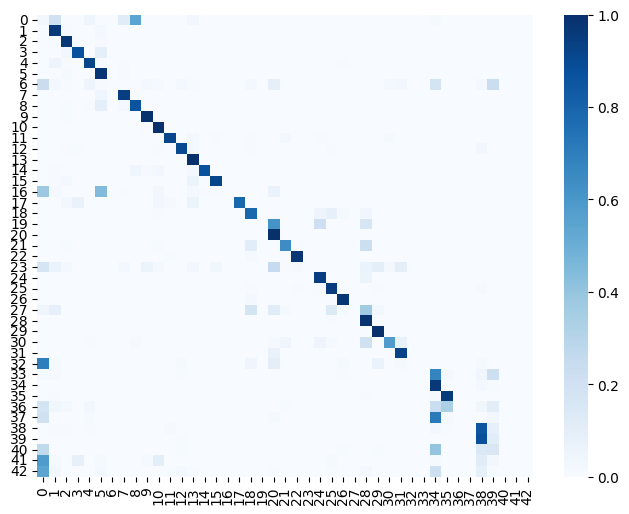

In [113]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [114]:
model_path = artifact_path / f'squeezenet.pth'

In [115]:
torch.save(model.state_dict(), model_path)

In [116]:
get_file_size(model_path)

'2.86MB'

In [117]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>